## Sentiment Analysis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nachi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nachi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Top 10 most frequent words:
trump: 17260
vote: 6244
people: 5906
harris: 4988
like: 4112
kamala: 4108
one: 3709
jesus: 3706
president: 3554
biden: 3434


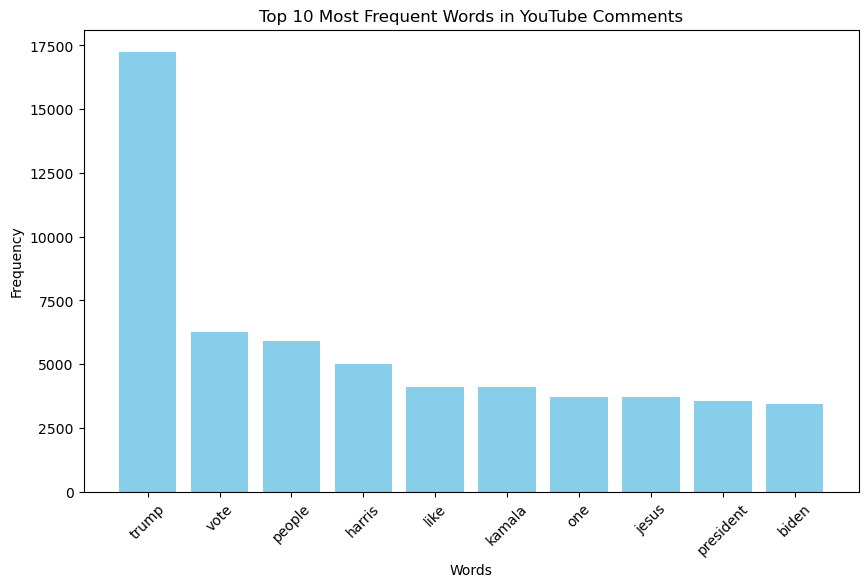

In [5]:
import pandas as pd
import re
import string
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt

# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stopwords set
stop_words = set(stopwords.words('english'))

# Define a function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
    return text

# Apply the cleaning function to the 'text' column
youtube_comments_df['cleaned_text'] = youtube_comments_df['text'].apply(lambda x: clean_text(str(x)))

# Tokenize the text and remove stopwords
def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove non-alphabetical tokens and stopwords
    return tokens

youtube_comments_df['tokens'] = youtube_comments_df['cleaned_text'].apply(tokenize_and_remove_stopwords)

# Flatten all tokens into a single list
all_tokens = [word for tokens in youtube_comments_df['tokens'] for word in tokens]

# Count the frequency of each word
word_counts = Counter(all_tokens)

# Get the top k most frequent words
k = 10  # You can set k to any number you like
top_k_words = word_counts.most_common(k)

# Display the top k words
print(f"Top {k} most frequent words:")
for word, count in top_k_words:
    print(f"{word}: {count}")

# Plotting the word frequency histogram
words, counts = zip(*top_k_words)  # Unzip the words and counts

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.title(f"Top {k} Most Frequent Words in YouTube Comments")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

Skipping file with no data: youtube_comments_-a-elTAJMtI.csv
Skipping file with no data: youtube_comments_1JbcfnuOLeA.csv
Skipping file with no data: youtube_comments_52vDK9QloH4.csv
Skipping file with no data: youtube_comments_5g3A00_LRRU.csv
Skipping file with no data: youtube_comments_5O-mhLcfg_A.csv
Skipping file with no data: youtube_comments_5ScB4oanA3A.csv
Skipping file with no data: youtube_comments_7HLqtRakfgA.csv
Skipping file with no data: youtube_comments_82c3tHFTk3g.csv
Skipping file with no data: youtube_comments_9M1m7j_nTWs.csv
Skipping file with no data: youtube_comments_abVZXLVUsrQ.csv
Skipping file with no data: youtube_comments_AgoOe2ew36s.csv
Skipping file with no data: youtube_comments_BUhN-xc3hcc.csv
Skipping file with no data: youtube_comments_DRLyLvyZFq0.csv
Skipping file with no data: youtube_comments_DSfCp_A0qbM.csv
Skipping file with no data: youtube_comments_EhjK7P3uboE.csv
Skipping file with no data: youtube_comments_faRdmt3My70.csv
Skipping file with no da

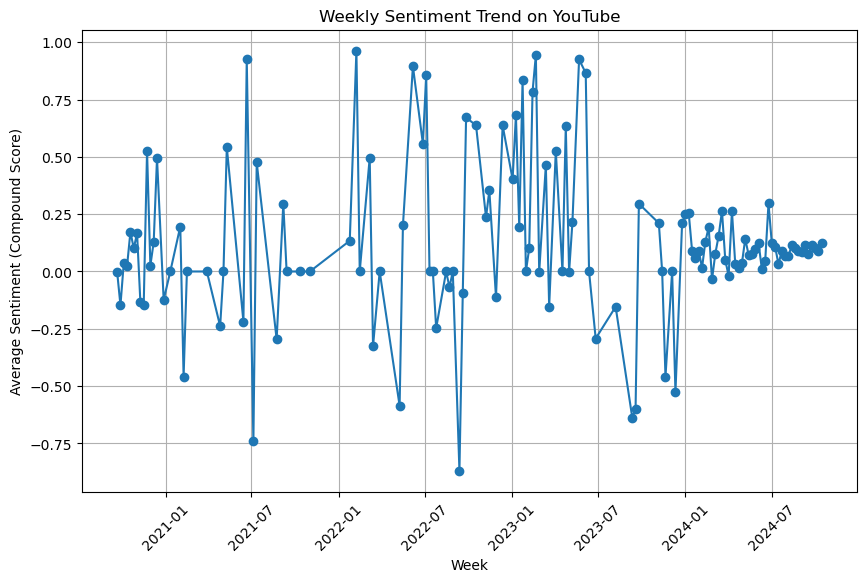

In [3]:
import pandas as pd
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Define the folder where the comment files are stored
comments_folder = 'youtube_data'

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to load all YouTube comments from the CSV files
def load_youtube_comments(comments_folder):
    all_comments = pd.DataFrame()

    for file_name in os.listdir(comments_folder):
        if file_name.startswith('youtube_comments_') and file_name.endswith('.csv'):
            file_path = os.path.join(comments_folder, file_name)
            try:
                video_comments = pd.read_csv(file_path)
                if not video_comments.empty:  # Check if the file is not empty
                    all_comments = pd.concat([all_comments, video_comments], ignore_index=True)
                else:
                    print(f"Skipping empty file: {file_name}")
            except pd.errors.EmptyDataError:
                print(f"Skipping file with no data: {file_name}")
    
    return all_comments

# Load the YouTube comments
youtube_comments_df = load_youtube_comments(comments_folder)

# Convert the 'published_at' column to datetime using ISO 8601 format
youtube_comments_df['published_at'] = pd.to_datetime(youtube_comments_df['published_at'], errors='coerce', format='%Y-%m-%dT%H:%M:%SZ')

# Drop rows where 'published_at' could not be converted (NaT values)
youtube_comments_df = youtube_comments_df.dropna(subset=['published_at'])

# Apply VADER sentiment analysis
def apply_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

# Add sentiment score to the DataFrame
youtube_comments_df['sentiment'] = youtube_comments_df['text'].apply(lambda x: apply_sentiment(str(x)))

# Extract the week number for weekly grouping
youtube_comments_df['week'] = youtube_comments_df['published_at'].dt.to_period('W').apply(lambda r: r.start_time)

# Group by week and calculate the average sentiment per week
weekly_sentiment_youtube = youtube_comments_df.groupby('week')['sentiment'].mean().reset_index()

# Plot the trend of weekly sentiment for YouTube data
plt.figure(figsize=(10, 6))
plt.plot(weekly_sentiment_youtube['week'], weekly_sentiment_youtube['sentiment'], marker='o')
plt.title('Weekly Sentiment Trend on YouTube')
plt.xlabel('Week')
plt.ylabel('Average Sentiment (Compound Score)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Topic Modelling

In [11]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Vectorize the text data (Bag of Words)
vectorizer = CountVectorizer(analyzer='word', 
                             token_pattern=r'\b[a-zA-Z]{3,}\b', # Consider words with 3 or more letters
                             stop_words='english', 
                             max_features=5000)  # You can adjust the number of features as needed

data_vectorized = vectorizer.fit_transform(youtube_comments_df['cleaned_text'])

# Create the LDA model
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)  # n_components is the number of topics
lda_model.fit(data_vectorized)

# Get the topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [13]:
# Display the top words for each topic
no_top_words = 10  # Number of top words per topic
display_topics(lda_model, vectorizer.get_feature_names_out(), no_top_words)

Topic 1:
trump, election, win, president, biden, polls, harris, going, states, just
Topic 2:
jesus, christ, god, world, life, says, bible, lord, brthe, people
Topic 3:
people, american, world, biden, lol, war, just, time, right, stop
Topic 4:
trump, vote, kamala, harris, people, america, voting, country, dont, president
Topic 5:
like, love, trump, good, just, cnn, thank, news, class, school


In [15]:
# Visualize with pyLDAvis
pyLDAvis.enable_notebook()
lda_vis = pyLDAvis.lda_model.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.display(lda_vis)

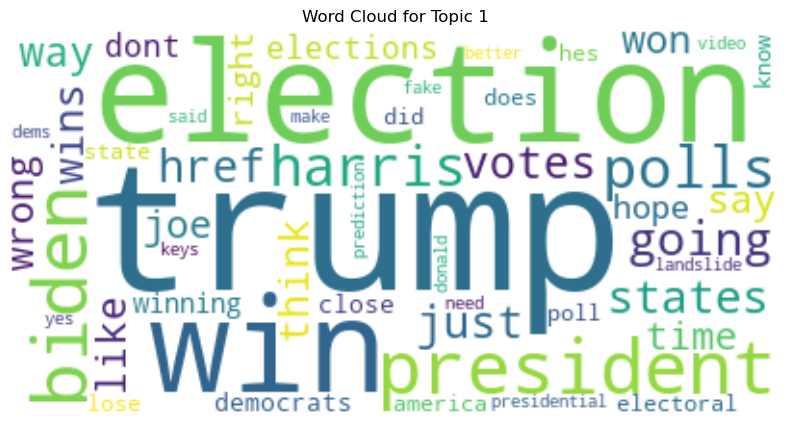

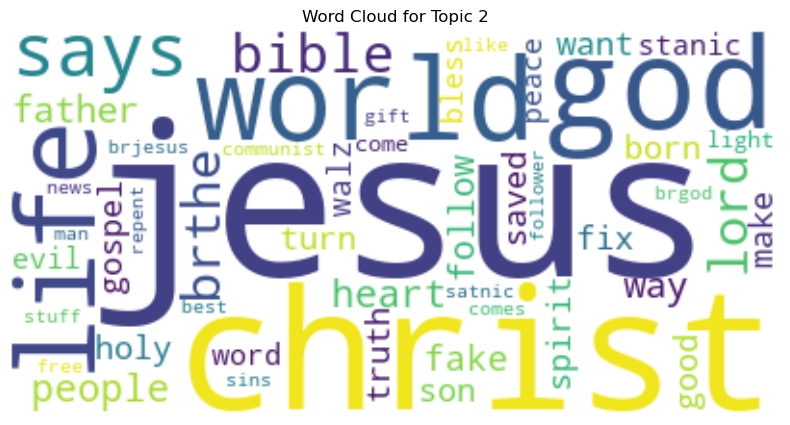

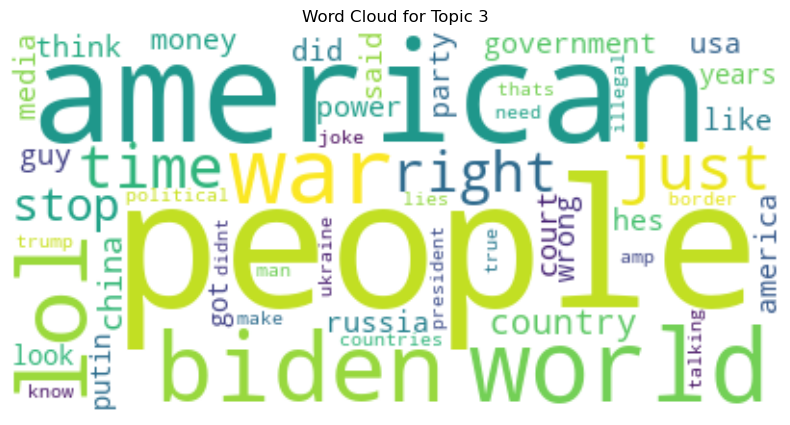

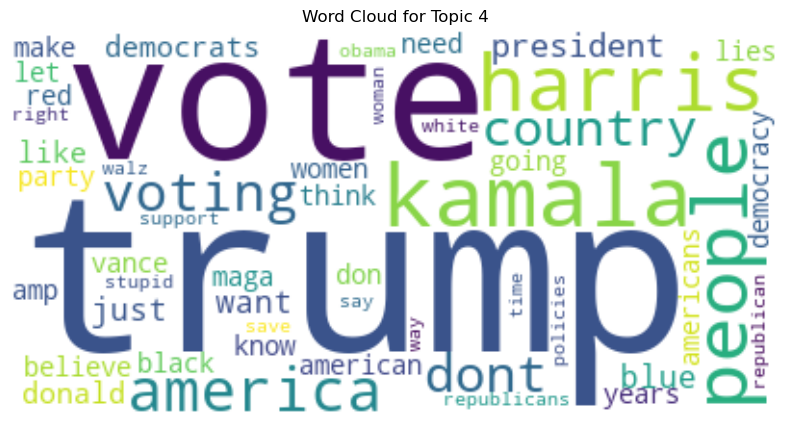

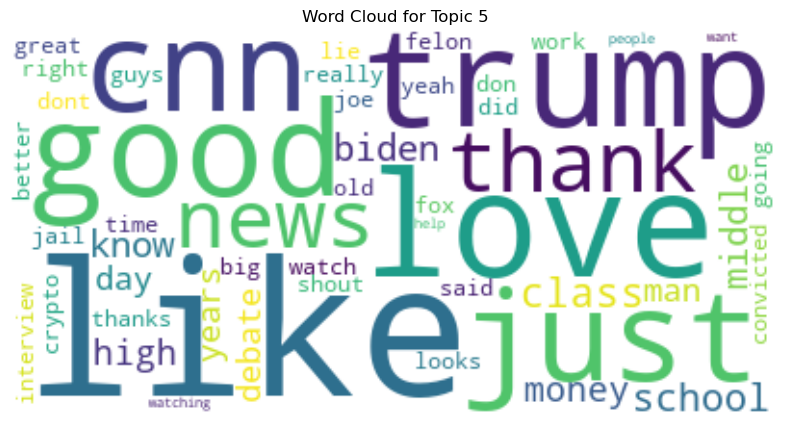

In [16]:
# Create Word Clouds for each topic
for topic_idx, topic in enumerate(lda_model.components_):
    plt.figure(figsize=(10, 5))
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(
        {vectorizer.get_feature_names_out()[i]: topic[i] for i in topic.argsort()[:-50 - 1:-1]}
    )
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_idx + 1}")
    plt.show()